In [2]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

2022-08-09 14:19:38.533918: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [4]:
filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))[::10]

In [5]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)

VALID_input = np.empty((L_valid,)+grid_shape+(5,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    VALID_input[i, ...] = data[...]

In [4]:
IN = tf.keras.Input((128, 128, 5))

X = IN

X = k_layers.CONV_stack(X, 32, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack1')
X = tf.keras.layers.Conv2D(32, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv1')(X)

X = k_layers.CONV_stack(X, 64, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack2')
X = tf.keras.layers.Conv2D(64, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv2')(X)

X = k_layers.CONV_stack(X, 128, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack3')
X = tf.keras.layers.Conv2D(128, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv3')(X)

X = k_layers.CONV_stack(X, 256, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack4')
X = tf.keras.layers.Conv2D(256, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv4')(X)

X = k_layers.CONV_stack(X, 512, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack5')
X = tf.keras.layers.Conv2D(512, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv5')(X)

D = tf.keras.layers.Flatten()(X)

D = tf.keras.layers.Dense(512, use_bias=False, name='dense1')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn1')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(128, use_bias=False, name='dense2')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn2')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(1, activation='sigmoid', name='head')(D)
#D = tf.keras.layers.Softmax()(D)

OUT = D

2022-08-09 09:55:30.990931: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-09 09:55:30.992579: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-09 09:55:31.067518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-09 09:55:31.067574: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-09 09:55:31.263648: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-09 09:55:31.263717: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [5]:
model = keras.models.Model(inputs=[IN,], outputs=[OUT,])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=2e-5))

In [6]:
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-5))

In [7]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100
batch_size_half = 50

valid_size = 1

In [10]:

batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'giga_chad'

model_name = '{}_pp5'.format(key)
model_path = temp_dir+model_name

In [18]:
X_batch = np.empty((batch_size, 128, 128, 5))*np.nan
Y_batch = np.empty((batch_size, 1))*np.nan

In [12]:
#Y_pred = model.predict([VALID_X])
record = 1.0 #np.nanmean(np.abs(Y_pred-VALID_Y))
print("Initial record: {}".format(record))

Initial record: 1.0


In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
from sklearn.metrics import classification_report, auc, roc_curve

In [15]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[...]
        
        Y_batch = np.ones((batch_size, 1))*0.9
        Y_batch[batch_size_half:, :] = 0.1
        
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input])
    
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))


2022-08-06 09:15:21.854712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-06 09:15:21.863332: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2022-08-06 09:15:22.223310: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-06 09:15:22.471256: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Validation loss improved from 1.0 to 0.3070705984376707
save to: /glade/work/ksha/NCAR/Keras_models/giga_chad_pp5


2022-08-06 09:18:05.606035: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/giga_chad_pp5/assets
--- 170.29836440086365 seconds ---
Validation loss improved from 0.3070705984376707 to 0.23173084801956478
save to: /glade/work/ksha/NCAR/Keras_models/giga_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/giga_chad_pp5/assets
--- 163.76627445220947 seconds ---
Validation loss improved from 0.23173084801956478 to 0.19102934409903438
save to: /glade/work/ksha/NCAR/Keras_models/giga_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/giga_chad_pp5/assets
--- 161.70661187171936 seconds ---
Validation loss improved from 0.19102934409903438 to 0.16631290497440943
save to: /glade/work/ksha/NCAR/Keras_models/giga_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/giga_chad_pp5/assets
--- 160.34792757034302 seconds ---
Validation loss improved from 0.16631290497440943 to 0.15051063018430288
save to: /glade/work/ksha/NCAR/

KeyboardInterrupt: 

In [25]:
key = 'giga_chad'
model_name = '{}_pp5'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.SGD(lr=1e-5))

key = 'giga_chad'
model_name = '{}_pp5_tune'.format(key)
model_path = temp_dir+model_name

In [26]:
Y_pred = model.predict([VALID_input])

fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
record_temp = auc(fpr, tpr)
record_temp = 1 - record_temp

print(record_temp)

0.14862659310944715


In [19]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[...]
        
        Y_batch = np.ones((batch_size, 1))*0.9
        Y_batch[batch_size_half:, :] = 0.1
        
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input])
    
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x2adc27484e50>
Traceback (most recent call last):
  File "/glade/work/ksha/anaconda3/lib/python3.9/weakref.py", line 370, in remove
KeyboardInterrupt: 

KeyboardInterrupt



In [20]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'giga_chad'
model_name = '{}_pp5_tune'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=5e-6))

key = 'giga_chad'
model_name = '{}_pp5_tune2'.format(key)
model_path = temp_dir+model_name

In [31]:
Y_pred = model.predict([VALID_input])

fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
record_temp = auc(fpr, tpr)
record_temp = 1 - record_temp

print(record_temp)

0.14645773453848665


In [27]:
record = record_temp

In [29]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[...]
        
        Y_batch = np.empty((batch_size, 1))
        
        Y_batch[:batch_size_half, 0] = np.random.uniform(0.95, 0.99, size=(batch_size_half,))
        Y_batch[batch_size_half:, 0] = np.random.uniform(0.01, 0.05, size=(batch_size_half,))
        
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input])
    
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))


Validation loss 0.14738612918000826 NOT improved


KeyboardInterrupt: 

In [24]:
np.random.uniform(0.85, 0.99, size=(batch_size_half,)).shape

(50,)

In [8]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'giga_chad'
model_name = '{}_pp5_tune2'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

### Classification results

In [9]:
from sklearn.metrics import classification_report, auc, roc_curve

In [5]:
#filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
#filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))

In [6]:
len(filename_valid_pos)

25920

In [13]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)

VALID_input = np.empty((L_valid,)+grid_shape+(5,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    
    VALID_input[i, ...] = data[...]

In [14]:
filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label_skew = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label_skew)

VALID_skew = np.empty((L_valid,)+grid_shape+(5,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    VALID_skew[i, ...] = data[...]

**Balanced verif**

In [15]:
Y_pred = model.predict([VALID_input])
Y_pred_label = Y_pred > 0.5

2022-08-09 11:43:09.877539: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-09 11:43:09.904252: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2022-08-09 11:43:12.033748: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-09 11:43:13.483326: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [16]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.78      0.82     33197
        True       0.71      0.84      0.77     22099

    accuracy                           0.80     55296
   macro avg       0.80      0.81      0.80     55296
weighted avg       0.81      0.80      0.80     55296



In [48]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.78      0.83     33142
        True       0.72      0.84      0.77     22154

    accuracy                           0.80     55296
   macro avg       0.80      0.81      0.80     55296
weighted avg       0.81      0.80      0.80     55296



In [37]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8871815021742365

In [17]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8871815021742365

In [18]:
fpr.shape

(17970,)

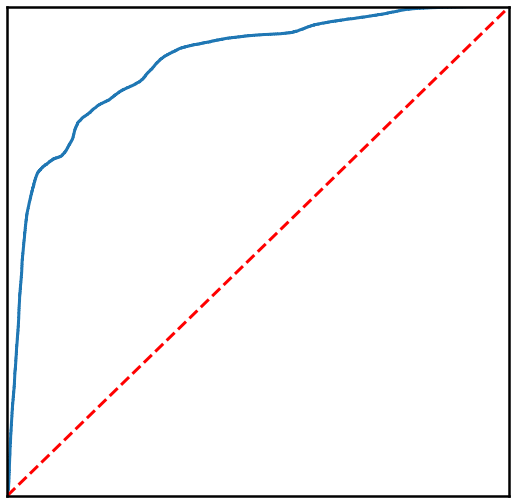

In [24]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

**Natural verif**

In [25]:
Y_pred = model.predict([VALID_skew])
Y_pred_label = Y_pred > 0.5
print(classification_report(Y_pred_label.ravel(), VALID_label_skew.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.97      0.92     26640
        True       0.67      0.33      0.44      5328

    accuracy                           0.86     31968
   macro avg       0.78      0.65      0.68     31968
weighted avg       0.84      0.86      0.84     31968



In [26]:
fpr, tpr, thresholds = roc_curve(VALID_label_skew.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8685229089653266

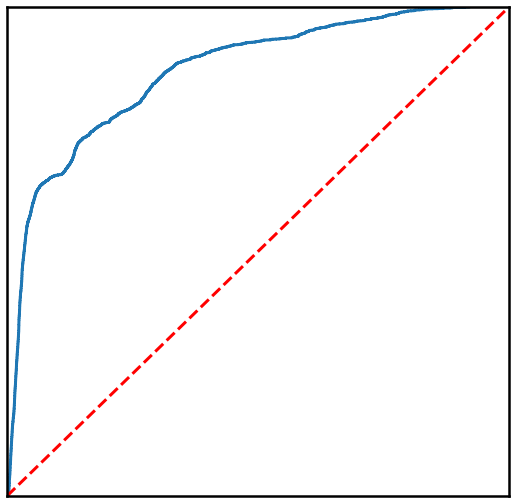

In [27]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

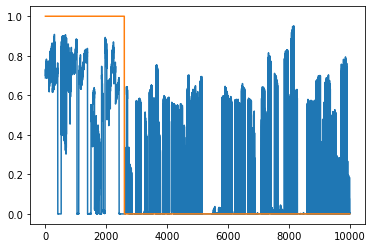

In [40]:
plt.plot(Y_pred.ravel()[:10000])
plt.plot(VALID_label_skew.ravel()[:10000])

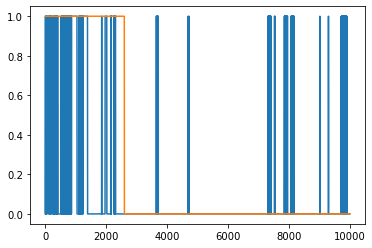

In [42]:
plt.plot(Y_pred.ravel()[:10000]>0.7)
plt.plot(VALID_label_skew.ravel()[:10000])